In [9]:
import chess
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
from sklearn.linear_model import LinearRegression

from p4_generate_dataset import SAMPLE_ELOS

In [10]:
df = pd.read_parquet("../data/stats_dataset.parquet")
df.head()

,fen,next_move,avg_elo,global_winrate,count,engine_move,fragility_score,delta,variance,score_base,...,recommended_move_2200,is_best_2200,is_engine_best_2200,frag_rec_2200,is_frag_best_2200,delta_rec_2200,is_delta_best_2200,mix_score_2200,mix_rec_2200,is_mix_best_2200
0,r1b1kb1r/ppp1pppp/2n1qn2/8/8/2N2N2/PPPPBPPP/R1...,d2d4,1296.660714,0.625000,112,d2d4,1.000000,0.426927,0.671902,0.699610,...,d2d4,True,True,e1g1,False,d2d4,True,0.426927,d2d4,True
1,r1b1kb1r/ppp1pppp/2n1qn2/8/8/2N2N2/PPPPBPPP/R1...,e1g1,1317.025455,0.603636,275,d2d4,1.000000,0.091592,0.255255,0.448949,...,d2d4,True,True,e1g1,False,d2d4,True,0.091592,d2d4,True
2,r1b1kbnr/ppp1pppp/2n1Q3/8/8/2N5/PPPP1PPP/R1B1K...,c8e6,1417.240803,0.484950,299,c8e6,0.719720,0.544044,0.192192,0.485319,...,c8e6,True,True,c8e6,True,c8e6,True,0.544044,c8e6,True
3,r1b1kbnr/ppp1pppp/2n1q3/8/8/2N2N2/PPPPBPPP/R1B...,c8d7,1391.673540,0.398625,291,e6d7,0.965465,0.022022,0.709710,0.565732,...,e6g6,False,False,c8d7,False,g8f6,True,0.022022,g8f6,True
4,r1b1kbnr/ppp1pppp/2n1q3/8/8/2N2N2/PPPPBPPP/R1B...,e6g6,1505.278317,0.543689,309,e6d7,0.965465,0.005005,0.958959,0.643143,...,e6g6,False,False,c8d7,False,g8f6,True,0.005005,g8f6,True


In [11]:
df.describe()

,avg_elo,global_winrate,count,fragility_score,delta,variance,score_base,winrate_500,score_500,mix_score_500,...,mix_score_850,winrate_1200,score_1200,mix_score_1200,winrate_1500,score_1500,mix_score_1500,winrate_2200,score_2200,mix_score_2200
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,...,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,1526.199247,0.477667,947.312500,0.716282,0.378009,0.495012,0.529768,0.189991,0.529768,0.547146,...,0.547146,0.474968,0.529768,0.513318,0.479046,0.529768,0.462577,0.438549,0.529768,0.378009
std,177.868277,0.071875,4065.276304,0.280875,0.270094,0.333755,0.175907,0.337035,0.175907,0.218560,...,0.218560,0.116775,0.175907,0.219774,0.083585,0.175907,0.230915,0.274908,0.175907,0.270094
min,1153.491870,0.216138,100.000000,0.000000,0.000000,0.000000,0.035202,0.000000,0.035202,0.001001,...,0.001001,0.000000,0.035202,0.001201,0.136364,0.035202,0.001502,0.000000,0.035202,0.000000
25%,1389.824050,0.435593,133.750000,0.648398,0.094219,0.159159,0.414331,0.000000,0.414331,0.439314,...,0.439314,0.411537,0.414331,0.370962,0.432470,0.414331,0.267111,0.333333,0.414331,0.094219
50%,1502.594541,0.478714,198.500000,0.767643,0.440274,0.582082,0.546616,0.000000,0.546616,0.579204,...,0.579204,0.472756,0.546616,0.553854,0.479344,0.546616,0.516266,0.469025,0.546616,0.440274
75%,1676.579927,0.514128,376.750000,0.938046,0.525526,0.706206,0.644394,0.333333,0.644394,0.703766,...,0.703766,0.535816,0.644394,0.654079,0.516218,0.644394,0.589902,0.566770,0.644394,0.525526
max,1894.221239,0.922414,35816.000000,1.000000,1.000000,1.000000,0.952119,1.000000,0.952119,0.985235,...,0.985235,1.000000,0.952119,0.987588,0.965517,0.952119,0.991116,1.000000,0.952119,1.000000


In [16]:
results = []

for elo in SAMPLE_ELOS:
    is_best_col = f"is_best_{elo}"
    is_engine_col = f"is_engine_best_{elo}"
    is_frag_col = f"is_frag_best_{elo}"
    is_delta_col = f"is_delta_best_{elo}"
    is_mix_col = f"is_mix_best_{elo}"

    avg_is_best = (df[is_best_col] * df["count"]).sum() / df["count"].sum()
    avg_is_engine_best = (df[is_engine_col] * df["count"]).sum() / df["count"].sum()
    avg_is_frag_best = (df[is_frag_col] * df["count"]).sum() / df["count"].sum()
    avg_is_delta_best = (df[is_delta_col] * df["count"]).sum() / df["count"].sum()
    avg_is_mix_best = (df[is_mix_col] * df["count"]).sum() / df["count"].sum()

    results.append({
        "elo": elo,
        "avg_is_best": avg_is_best,
        "avg_is_engine_best": avg_is_engine_best,
        "avg_is_frag_best": avg_is_frag_best,
        "avg_is_delta_best": avg_is_delta_best,
        "avg_is_mix_best": avg_is_mix_best,
    })

pd.DataFrame(results)

,elo,avg_is_best,avg_is_engine_best,avg_is_frag_best,avg_is_delta_best,avg_is_mix_best
0,500,0.590659,0.416330,0.663765,0.583703,0.583703
1,850,0.580190,0.464130,0.575971,0.622575,0.622575
2,1200,0.613384,0.597777,0.566751,0.784481,0.784481
3,1500,0.609318,0.458682,0.641976,0.660219,0.660219
4,2200,0.559296,0.376950,0.643906,0.544311,0.544311


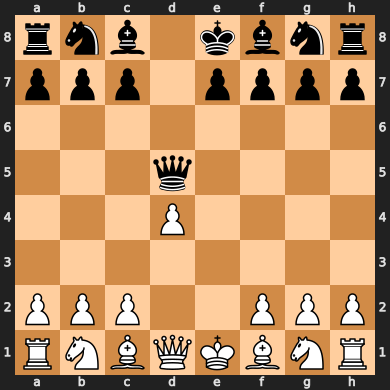

In [14]:
random_fen = df["fen"].sample(1).iloc[0]
filtered = df[df["fen"] == random_fen]
chess.Board(random_fen)

In [15]:
filtered

,fen,next_move,avg_elo,global_winrate,count,engine_move,fragility_score,delta,variance,score_base,...,recommended_move_2200,is_best_2200,is_engine_best_2200,frag_rec_2200,is_frag_best_2200,delta_rec_2200,is_delta_best_2200,mix_score_2200,mix_rec_2200,is_mix_best_2200
139,rnb1kbnr/ppp1pppp/8/3q4/3P4/8/PPP2PPP/RNBQKBNR...,c7c5,1677.732394,0.415493,142,b8c6,0.0,0.111111,0.703704,0.271605,...,d5e4,True,False,d5d8,False,e7e5,False,0.111111,e7e5,False
140,rnb1kbnr/ppp1pppp/8/3q4/3P4/8/PPP2PPP/RNBQKBNR...,c7c6,1815.121134,0.445876,388,b8c6,0.0,0.094595,0.011011,0.035202,...,d5e4,True,False,d5d8,False,e7e5,False,0.094595,e7e5,False
141,rnb1kbnr/ppp1pppp/8/3q4/3P4/8/PPP2PPP/RNBQKBNR...,c8f5,1641.982143,0.448980,392,b8c6,0.0,0.067568,0.584585,0.217384,...,d5e4,True,False,d5d8,False,e7e5,False,0.067568,e7e5,False
142,rnb1kbnr/ppp1pppp/8/3q4/3P4/8/PPP2PPP/RNBQKBNR...,d5a5,1665.932796,0.419355,372,b8c6,0.0,0.065566,0.698699,0.254755,...,d5e4,True,False,d5d8,False,e7e5,False,0.065566,e7e5,False
143,rnb1kbnr/ppp1pppp/8/3q4/3P4/8/PPP2PPP/RNBQKBNR...,d5d8,1713.299501,0.470882,1202,b8c6,0.0,0.099099,0.019019,0.039373,...,d5e4,True,False,d5d8,False,e7e5,False,0.099099,e7e5,False
144,rnb1kbnr/ppp1pppp/8/3q4/3P4/8/PPP2PPP/RNBQKBNR...,d5e4,1426.394366,0.483568,213,b8c6,0.0,0.036036,0.942943,0.326326,...,d5e4,True,False,d5d8,False,e7e5,False,0.036036,e7e5,False
145,rnb1kbnr/ppp1pppp/8/3q4/3P4/8/PPP2PPP/RNBQKBNR...,d5e6,1482.028761,0.393805,452,b8c6,0.0,0.020020,0.705706,0.241909,...,d5e4,True,False,d5d8,False,e7e5,False,0.020020,e7e5,False
146,rnb1kbnr/ppp1pppp/8/3q4/3P4/8/PPP2PPP/RNBQKBNR...,e7e5,1749.026860,0.454545,484,b8c6,0.0,0.471471,0.248248,0.239907,...,d5e4,True,False,d5d8,False,e7e5,False,0.471471,e7e5,False
147,rnb1kbnr/ppp1pppp/8/3q4/3P4/8/PPP2PPP/RNBQKBNR...,e7e6,1546.253425,0.458904,146,b8c6,0.0,0.105606,0.133726,0.079777,...,d5e4,True,False,d5d8,False,e7e5,False,0.105606,e7e5,False
148,rnb1kbnr/ppp1pppp/8/3q4/3P4/8/PPP2PPP/RNBQKBNR...,g8f6,1727.587089,0.434836,821,b8c6,0.0,0.108609,0.222723,0.110444,...,d5e4,True,False,d5d8,False,e7e5,False,0.108609,e7e5,False


# Regression Analysis

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 75 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fen                    256 non-null    object 
 1   next_move              256 non-null    object 
 2   avg_elo                256 non-null    float64
 3   global_winrate         256 non-null    float64
 4   count                  256 non-null    int64  
 5   engine_move            256 non-null    object 
 6   fragility_score        256 non-null    float64
 7   delta                  256 non-null    float64
 8   variance               256 non-null    float64
 9   score_base             256 non-null    float64
 10  winrate_500            256 non-null    float64
 11  historical_best_500    256 non-null    object 
 12  score_500              256 non-null    float64
 13  recommended_move_500   256 non-null    object 
 14  is_best_500            256 non-null    bool   
 15  is_eng

In [18]:
# df["f_cross_d"] = df["fragility_score"] * df["delta"]
# df["f_cross_v"] = df["fragility_score"] * df["variance"]
# df["d_cross_v"] = df["delta"] * df["variance"]

selected_features = ["fragility_score", "delta", "variance", "score_base"] #"f_cross_d", "f_cross_v", "d_cross_v", ]
X = df[selected_features]
y = df["is_best_1500"]

In [19]:
model = LinearRegression()
model.fit(X, y)

for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.3f}")

fragility_score: 0.303
delta: 0.396
variance: 0.093
score_base: 0.264


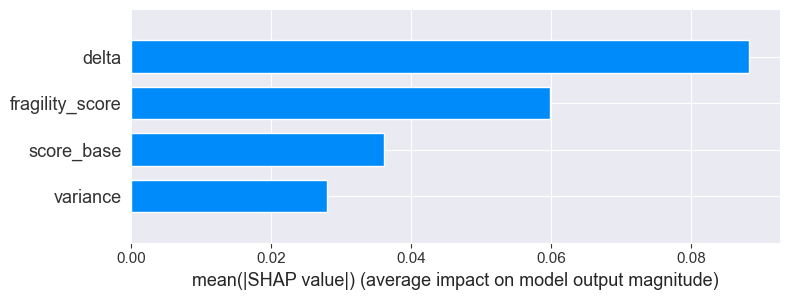

In [20]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, plot_type="bar")

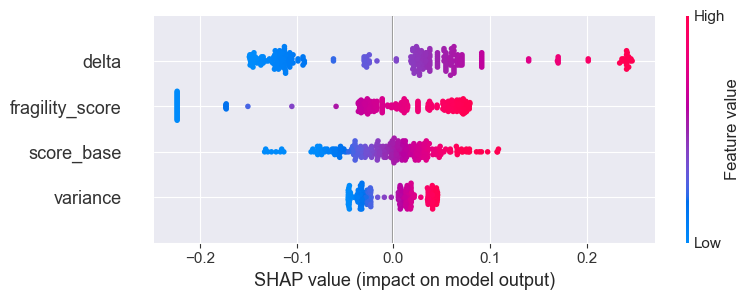

In [21]:
shap.summary_plot(shap_values, X, show=True)

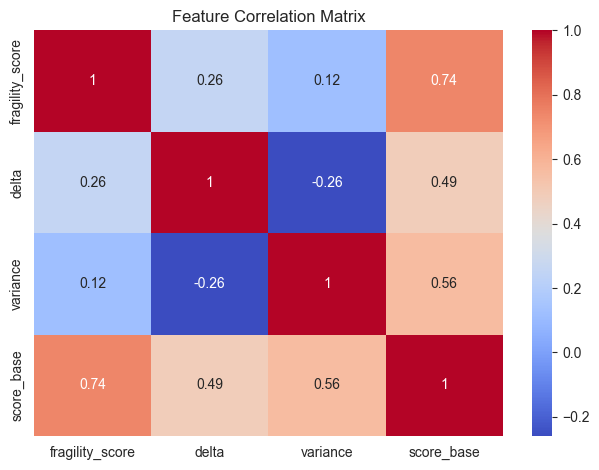

In [22]:
sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()